# Find pairs

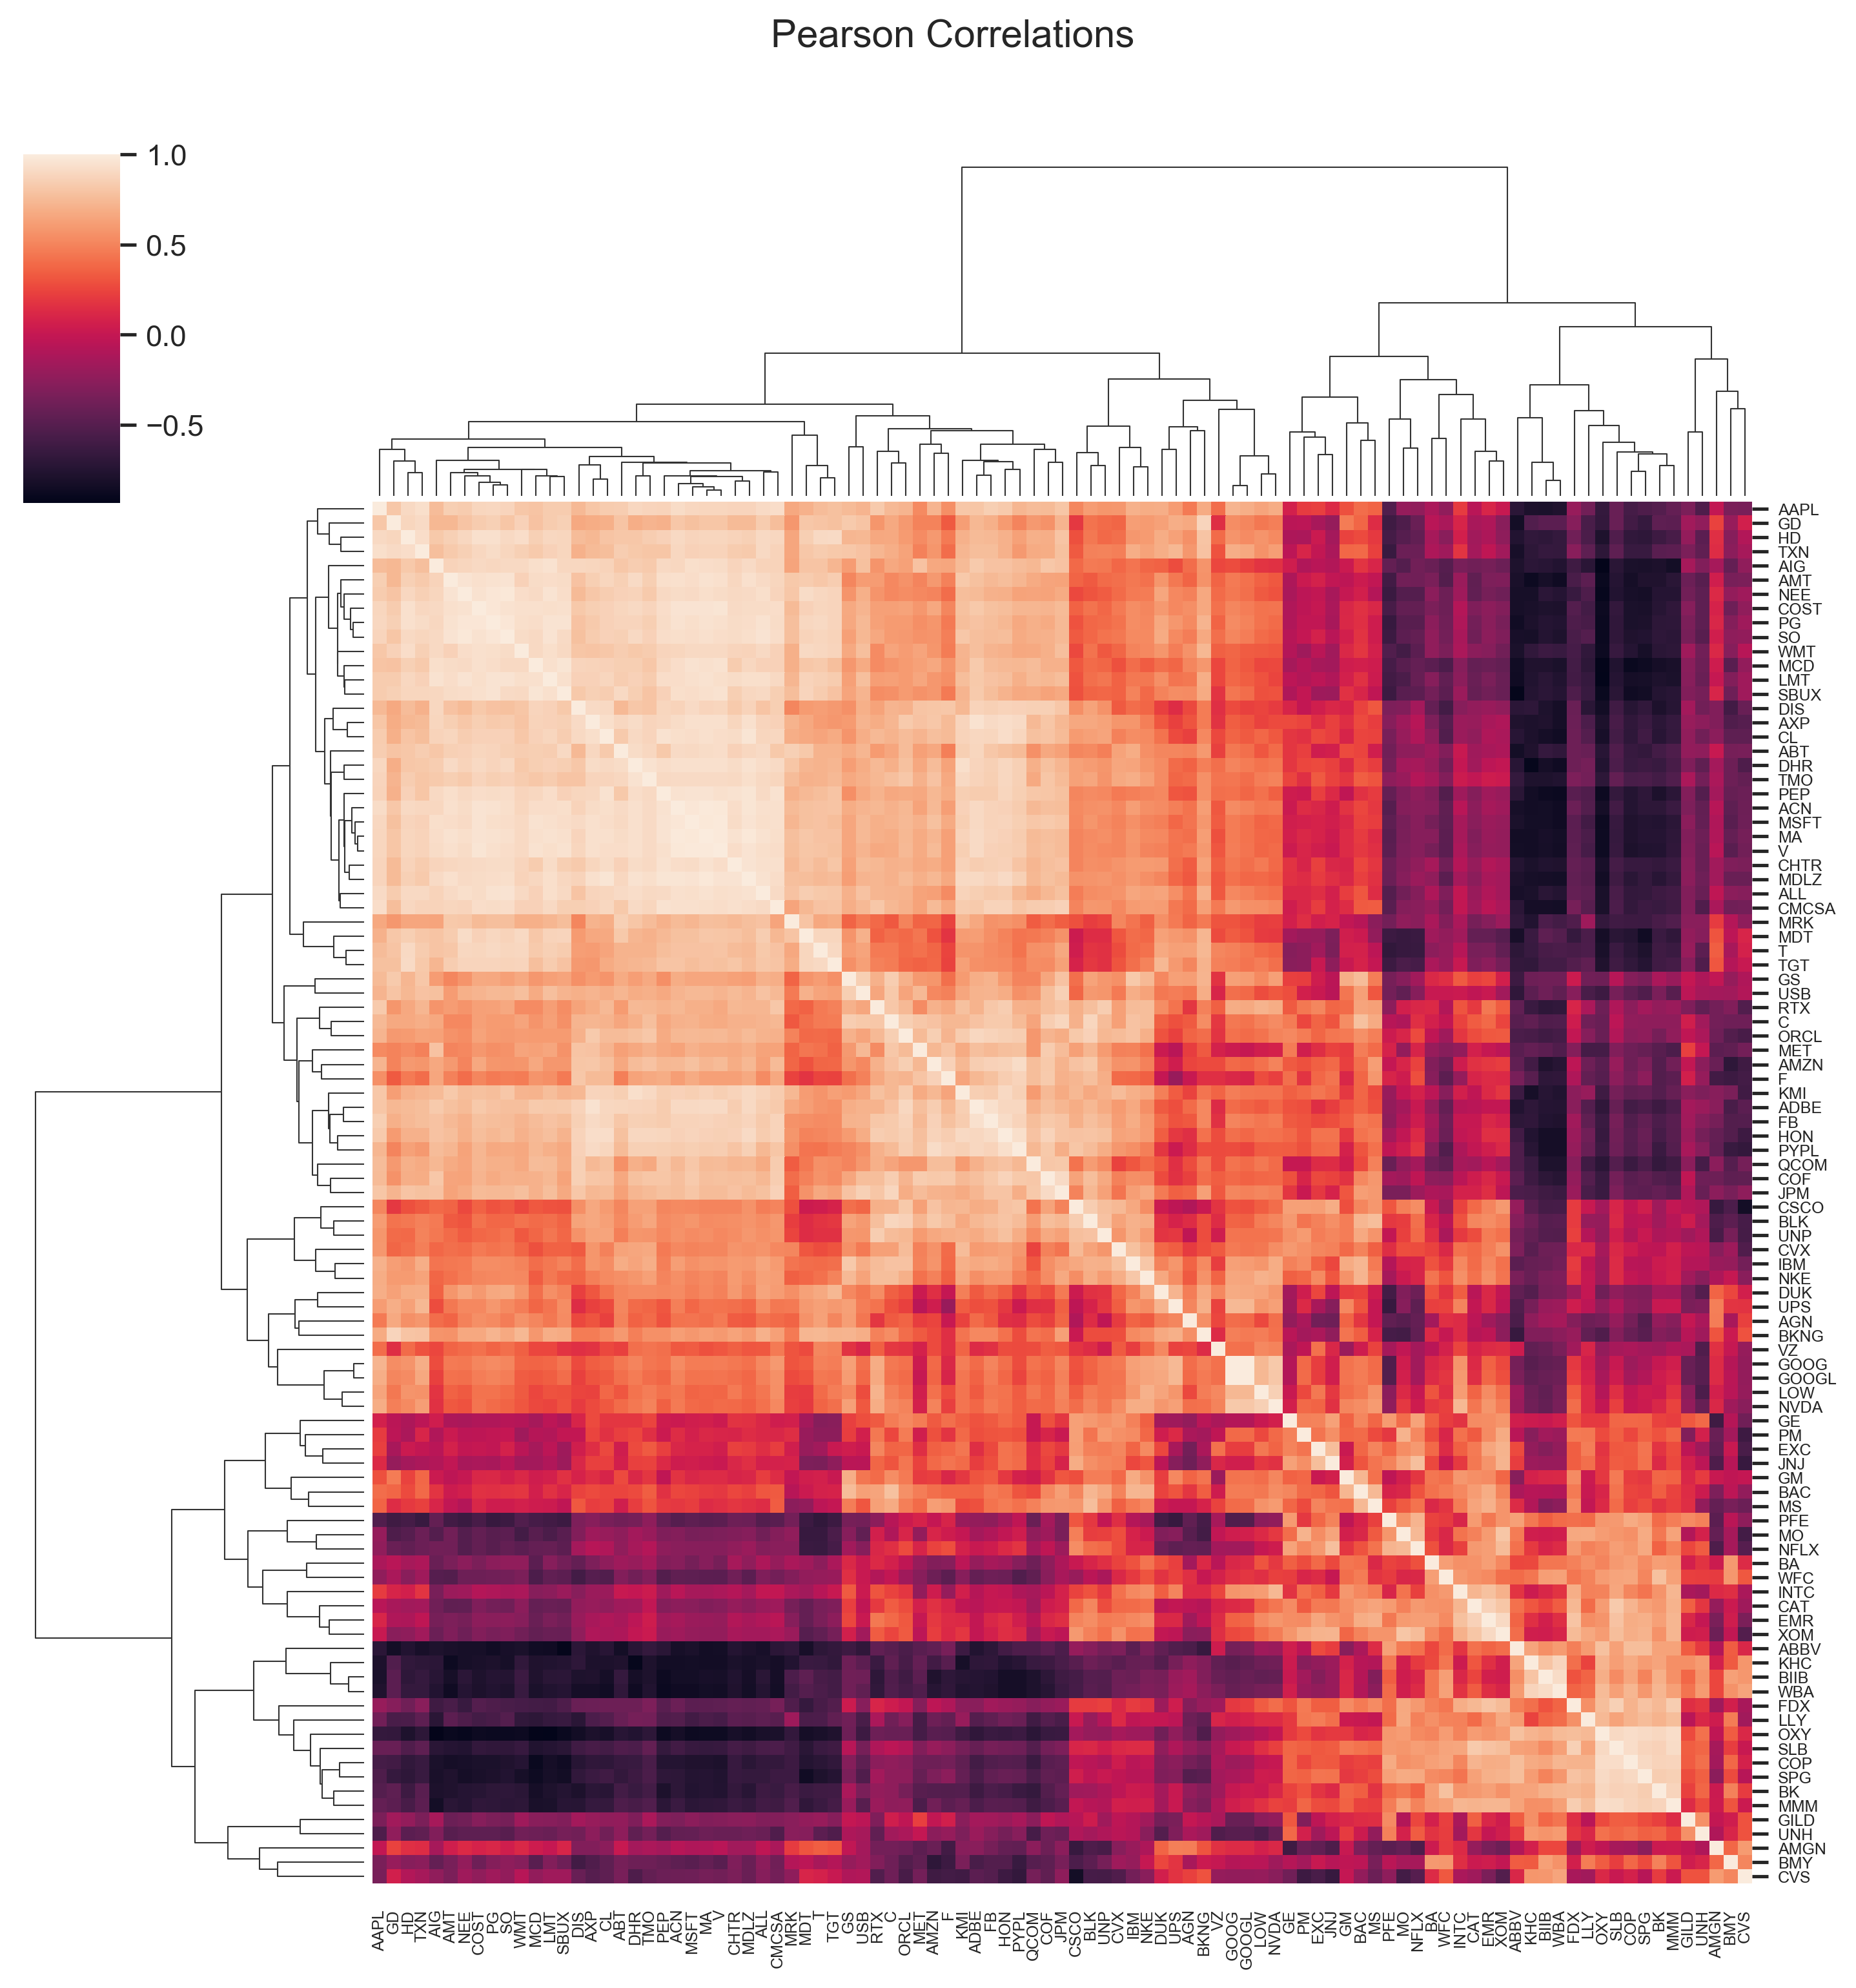

In [2]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os
from functools import reduce
from statsmodels.tsa.stattools import coint


sns.set(style='white')
plt.rcParams['figure.dpi'] = 300

# Retrieve intraday price data and combine them into a DataFrame.
# 1. Load downloaded prices from folder into a list of dataframes.
folder_path = "STATICS"
file_names  = os.listdir(folder_path)
tickers     = [name.split('.')[0] for name in file_names]
df_list     = [pd.read_csv(os.path.join(folder_path, name)) for name in file_names]

# 2. Replace the closing price column name by the ticker.
for i in range(len(df_list)):
    df_list[i].rename(columns={'close': tickers[i]}, inplace=True)

# 3. Merge all price dataframes. Extract roughly the first 70% data.
df  = reduce(lambda x, y: pd.merge(x, y, on='date'), df_list)
idx = "2019-10-01"
df  = df[df.date<idx]
df_test = df[df.date>=idx]


# 4. Cluster stocks with correlation matrix as distance metrics

from scipy.spatial import distance
from scipy.cluster import hierarchy

pearson_corr  = df[tickers].corr()
correlations_array = np.asarray(pearson_corr)

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='average')

g=sns.clustermap(pearson_corr, row_linkage=row_linkage, col_linkage=col_linkage, method="average"
                 ,yticklabels=True,xticklabels=True)
g.fig.suptitle('Pearson Correlations', y=1.05)
ax = g.ax_heatmap
ax.tick_params(axis='y',labelsize=6) 
ax.tick_params(axis='x',labelsize=6)
plt.show()


In [26]:
# Among top N highly-correlated pairs, select the best one with minimum cointegration p-value

import pickle

corr_matrix=pearson_corr.values.copy()
N=20
pair_lst=[]

for i in range(N):
    p,q=np.unravel_index(np.argmax(corr_matrix-np.identity(corr_matrix.shape[0]), axis=None), corr_matrix.shape)
    print(tickers[p],tickers[q],corr_matrix[p,q])
    
    # Calculate the p-value of cointegration test for pairs.
    x = df[tickers[p]]
    y = df[tickers[q]]
    _, p_value, _ = coint(x, y)
    
    pair_lst.append((tickers[p],tickers[q],corr_matrix[p,q],p_value))
    print('The p_value of {}-{} pair cointegration is: {}'.format(tickers[p],tickers[q],p_value))
    print("----------------------------------------------------------------------")
    
    corr_matrix[p,q],corr_matrix[q,p]=0.,0.
    
pair_lst=sorted(pair_lst,key=lambda x:x[-1])

with open("top{}correlatedpairs.p".format(N),"wb") as f:
    pickle.dump(pair_lst,f)

GOOG GOOGL 0.9987764428719094
The p_value of GOOG-GOOGL pair cointegration is: 0.04938849728219575
----------------------------------------------------------------------
MA V 0.9905393671710663
The p_value of MA-V pair cointegration is: 0.02780461558962077
----------------------------------------------------------------------
MSFT V 0.9863890139219335
The p_value of MSFT-V pair cointegration is: 0.05564934458964988
----------------------------------------------------------------------
ACN MA 0.985757309428004
The p_value of ACN-MA pair cointegration is: 0.003809144294503017
----------------------------------------------------------------------
ACN V 0.9847324453904945
The p_value of ACN-V pair cointegration is: 0.004459069367061881
----------------------------------------------------------------------
NEE SO 0.9810682777721692
The p_value of NEE-SO pair cointegration is: 0.017725871660645483
----------------------------------------------------------------------
MA MSFT 0.97830815406389

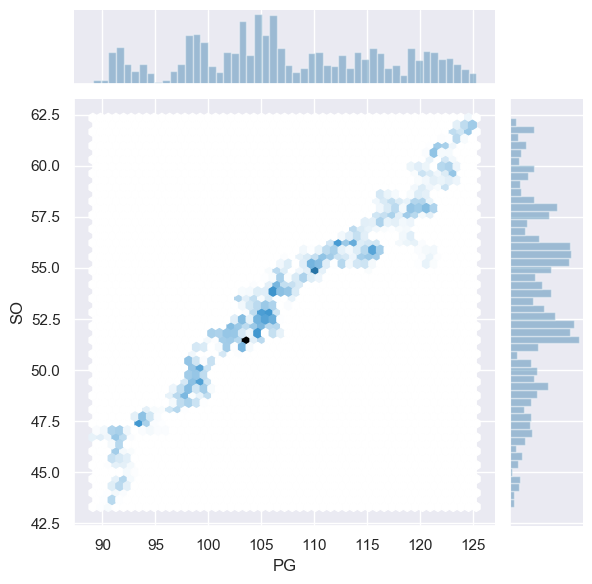

In [41]:
# Plot the marginal distributions.

plt.rcParams['figure.dpi'] = 100
sns.set(style='darkgrid')
sns.jointplot(df[pair_lst[0][0]], df[pair_lst[0][1]],  kind='hex', color='#2874A6')
plt.show()

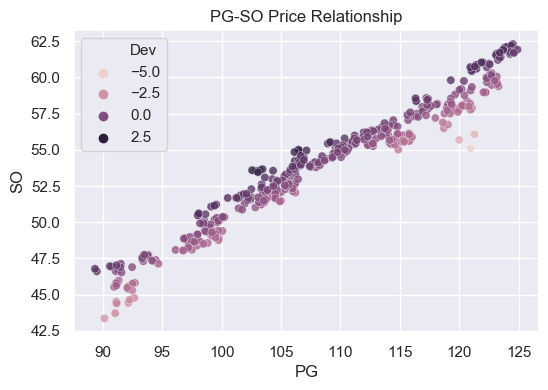

In [42]:
# Plot the linear relationship of the pair.

from sklearn.linear_model import LinearRegression
plt.rcParams['figure.dpi'] = 100

df2 = df[[pair_lst[0][0], pair_lst[0][1]]].copy()

model=LinearRegression()
model.fit(df2[pair_lst[0][0]].values.reshape(-1, 1),df2[pair_lst[0][1]].values)

spread = df2[pair_lst[0][1]] - model.coef_*df2[pair_lst[0][0]]
mean_spread = spread.mean()
df2['Dev'] = spread - mean_spread
rnd = np.random.choice(len(df), size=500)
sns.scatterplot(x=pair_lst[0][0], y=pair_lst[0][1], hue='Dev', linewidth=0.3, alpha=0.8,
                data=df2.iloc[rnd, :]).set_title('{}-{} Price Relationship'.format(pair_lst[0][0],pair_lst[0][1]))
plt.show()

The slope is 0.43673862734093133


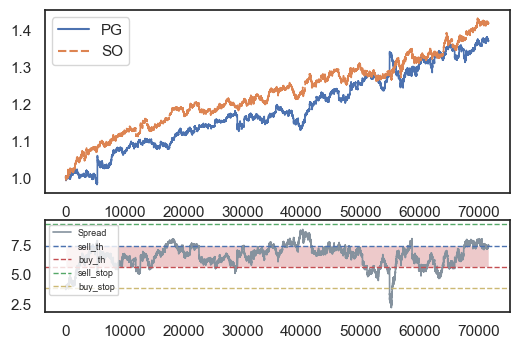

In [9]:
# Plot the historical prices and the spreads for a sample period.

from sklearn.linear_model import LinearRegression
plt.rcParams['figure.dpi'] = 100

def plot_spread(df, ticker1, ticker2, idx, th = None, stop = None):

    px1 = df[ticker1].iloc[idx] / df[ticker1].iloc[idx[0]]
    px2 = df[ticker2].iloc[idx] / df[ticker2].iloc[idx[0]]

    sns.set(style='white')

    # Set plotting figure
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})

    # Plot the 1st subplot
    sns.lineplot(data=[px1, px2], linewidth=1.2, ax=ax[0])
    ax[0].legend(loc='upper left')

    # Calculate the spread and other thresholds
    model=LinearRegression()
    model.fit(df[ticker1].values.reshape(-1, 1),df[ticker2].values)
    print("The slope is",model.coef_[0])
    
    spread = df[ticker2].iloc[idx] - model.coef_*df[ticker1].iloc[idx]
    mean_spread = spread.mean()
    std_spread = spread.std()
    
    if stop==None:
        stop=3*std_spread
    if th==None:
        th=std_spread
    
    sell_th     = mean_spread + th
    buy_th      = mean_spread - th
    sell_stop   = mean_spread + stop
    buy_stop    = mean_spread - stop

    # Plot the 2nd subplot
    sns.lineplot(data=spread, color='#85929E', ax=ax[1], linewidth=1.2)
    ax[1].axhline(sell_th,   color='b', ls='--', linewidth=1, label='sell_th')
    ax[1].axhline(buy_th,    color='r', ls='--', linewidth=1, label='buy_th')
    ax[1].axhline(sell_stop, color='g', ls='--', linewidth=1, label='sell_stop')
    ax[1].axhline(buy_stop,  color='y', ls='--', linewidth=1, label='buy_stop')
    ax[1].fill_between(idx, sell_th, buy_th, facecolors='r', alpha=0.3)
    ax[1].legend(loc='upper left', labels=['Spread', 'sell_th', 'buy_th', 'sell_stop', 'buy_stop'], prop={'size':6.5})
    plt.show()

plot_spread(df, pair_lst[0][0], pair_lst[0][1], range(len(df)))